# UE 11
## Ziele der Übung: Modell weiterentwickeln
- Residuallast berechnen
- Optimierungsmodell
    - mehr Zeitschritte
    - mehr Kraftwerke 
    - binäre Variable für den Kraftwerkseinsatz
    - Start-up costs
    - Speicher
- Ergebnisse plotten

## Änderungen zur Übung
- Parameter-Definition Speicherstand zu Beginnn der Modellierung --> Definition der Parameter vor den Variablen möglich, da es nur Konstanten sind (S_0=0 statt S_lvl[0]=0)
- Speicher-Nebenbedingung für t=0 --> Auch in t=0 kann das Level>0 sein, da eingespeichert werden kann:
    - S_lvl[0]=S_0+S_in[0]-S_out[0]

## Bibliotheken einlesen
- numpy: "Numerical Python" 
- pandas: Package for Datahandling
- gurobipy: Package for linear optimization
- matplotlib.pyplot: Package for plotting Data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *

## 1. Residuallast berechnen
- Last und EE-Erzeugung aus .csv-Dateien einlesen
- in Dataframe speichern und Zeitstempel erstellen
- Residuallast berechnet (Last-EE) und in neuem Dataframe speichern
- Residuallast plotten

### Last

In [2]:
# Import csv
year = 2015
path_load = './Input/Load_'+str(year)+'.csv'
#path = './Input/Load_2015.csv'

# Read from csv
df_load = pd.read_csv(path_load, sep=';', decimal=',')
df_load.tail()

,Datum,Zeit,Wert in MW
35040,31.12.2015,23:00,1632
35041,31.12.2015,23:15,1760
35042,31.12.2015,23:30,1648
35043,31.12.2015,23:45,1792
35044,31.12.2015,00:00,1664


In [3]:
# Create column including date and time
df_load['Timestamp'] = df_load['Datum']+" "+df_load['Zeit']
# Create timestamp from column
df_load['Timestamp'] = pd.to_datetime(df_load['Timestamp'], utc='Europe/Berlin')
# Set index to timestamp
df_load.set_index('Timestamp', inplace=True)
# Drop columns Datum and Zeit
df_load.drop(['Datum','Zeit'], axis=1, inplace=True)
df_load.head()

,Wert in MW
Timestamp,
2015-01-01 00:00:00+00:00,1664
2015-01-01 00:15:00+00:00,2224
2015-01-01 00:30:00+00:00,2064
2015-01-01 00:45:00+00:00,2224
2015-01-01 01:00:00+00:00,2144


### EE-Erzeugung

In [4]:
# Import csv
year = 2015
path_EE = './Input/EE_gen_'+str(year)+'.csv'
# Read from csv
df_EE = pd.read_csv(path_EE, sep=';', decimal=',')
df_EE.tail()

,cet_cest_timestamp,actual_Solar,actual_wind
35035,2015-12-31T23:45:00+0100,0.0,607.5
35036,2016-01-01T00:00:00+0100,0.0,600.9
35037,2016-01-01T00:15:00+0100,0.0,588.0
35038,2016-01-01T00:30:00+0100,0.0,579.0
35039,2016-01-01T00:45:00+0100,0.0,573.3


In [5]:
# Set datetime format
df_EE['cet_cest_timestamp'] = pd.to_datetime(df_EE['cet_cest_timestamp'], utc='Europe/Berlin')
# Set index
df_EE.set_index('cet_cest_timestamp', inplace=True)
df_EE.head()

,actual_Solar,actual_wind
cet_cest_timestamp,,
2015-01-01 00:00:00+00:00,0.0,683.4
2015-01-01 00:15:00+00:00,0.0,692.7
2015-01-01 00:30:00+00:00,0.0,692.4
2015-01-01 00:45:00+00:00,0.0,701.1
2015-01-01 01:00:00+00:00,0.0,711.3


### Residuallast

In [6]:
# Create new dataframe
df_res_load = pd.DataFrame()
df_res_load['Residuallast in MW'] = df_load['Wert in MW'] - df_EE['actual_Solar'] - df_EE['actual_wind']

df_res_load.head()

,Residuallast in MW
2015-01-01 00:00:00+00:00,980.6
2015-01-01 00:00:00+00:00,1492.6
2015-01-01 00:15:00+00:00,1531.3
2015-01-01 00:30:00+00:00,1371.6
2015-01-01 00:45:00+00:00,1522.9


### Auswahl einer Woche

In [7]:
# Create new dataframe
# Define week
week = 10
# New dataframe
df_res_load_cropped = pd.DataFrame()
# mask df_res_load
mask = df_res_load.index.week == week
# Copy df_res_load where week is 10
df_res_load_cropped = df_res_load.loc[mask]
# Resample to hourly load
df_res_load_cropped = df_res_load_cropped.resample('h').mean()

df_res_load_cropped.head()

,Residuallast in MW
2015-03-02 00:00:00+00:00,1063.350
2015-03-02 01:00:00+00:00,881.375
2015-03-02 02:00:00+00:00,748.850
2015-03-02 03:00:00+00:00,566.025
2015-03-02 04:00:00+00:00,526.075


### Residuallast plotten

c:\python36\lib\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


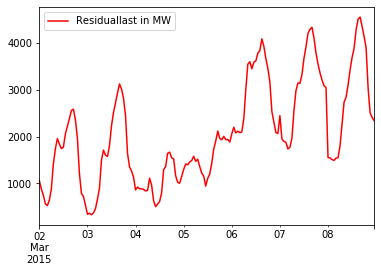

In [8]:
df_res_load_cropped.plot(kind='line', c='r', style ='-')
plt.show()

## 2. Modellierung
- Kraftwerksparameter aus .csv-Datei einlesen
- Modell aufstellen
    - Kraftwerksparameter definiern
    - Variablen definieren
    - Nebenbedingungen einfügen, die durch die Parameter der KW definiert werden
        - Maximale Leistung / Minimale Leistung
        - Emissionen / CO2-Kosten --> Kosten 0.02 €/kg, Limit 3.500.000.000.000.000 kg_CO2/MWh_el
        - Nachfrage
        - Start-Up Costs
        - Speicher
            - in t=0 leer
            - max. 200 MWh
    - Zielfunktion festlegen

### Kraftwerksparameter

In [9]:
# Define path
path_PP = './Input/PP_List.csv'
# read csv
df_PP = pd.read_csv(path_PP, sep=';', decimal=',')
df_PP

,Fuel,Pmax in MW,Pmin in MW,variable costs in EUR/MWh,startup cost in EUR,fix operating cost in EUR/h,Emissionsfaktor kg_CO2/MWh_el
0,Biomass,82,1.00,60,10,4600,0
1,Gas,1450,1.00,35,280,3800,455
2,Hard_Coal,1487,223.05,15,420,7000,891
3,Lignite,1320,264.00,6,420,7800,1225
4,Uranium,666,219.78,5,10000,11000,0
5,Oil,135,1.00,38,280,3800,776
6,Water,146,1.00,0,1,5000,0


### Modell erstellen

In [10]:
# Create Model
M = Model('Unit Commitment')

Using license file c:\gurobi900\gurobi.lic
Academic license - for non-commercial use only


### Parameter

In [11]:
# Load
load_model = df_res_load_cropped['Residuallast in MW'].copy()

# Power Plants
PP_model = df_PP.copy()

# Pmax
P_max = PP_model['Pmax in MW']

# Pmin
P_min = PP_model['Pmin in MW']

# cost
cost_var = PP_model['variable costs in EUR/MWh']
cost_su = PP_model['startup cost in EUR']
cost_fix = PP_model['fix operating cost in EUR/h']

# emissions
e_factor = PP_model['Emissionsfaktor kg_CO2/MWh_el']
e_cost = 0.02 # in EUR/kg
e_limit = 3500000000000000 # in kg CO2

# Storage
S_max = 200 # maximales Speichervolumen in MWh
S_0 = 0 #initialer Speicherstand in t=0

# Sets for Timesteps and Powerplants
T = range(len(df_res_load_cropped))
I = range(len(df_PP))

### Variablen

In [12]:
# Production
X = M.addVars(T, I, vtype=GRB.CONTINUOUS, name='Production of PP i in timestep t')

# Power Plant Status, 1 = operating, 0 = not operating
Y = M.addVars(T, I, vtype=GRB.BINARY, name='Status of PP i in timestep t')

# Start-up Status, 1 = start-up, 0 = not start-up
SU = M.addVars(T, I, vtype=GRB.BINARY, name='Indicator of PP i is starting up in timestep t')

# Emissions (define variable for easier use later on)
E = M.addVars(T, I, vtype=GRB.CONTINUOUS, name='Emissions of PP i in timestep t')

# Storage
S_lvl = M.addVars(T, vtype=GRB.CONTINUOUS, name='Storage level in timestep t')
S_in = M.addVars(T, vtype=GRB.CONTINUOUS, name='Added Storage in timestep t')
S_out = M.addVars(T, vtype=GRB.CONTINUOUS, name='Storage out in timestep t')

### Nebenbedingungen
- Maximale und minimale Erzeugung
- Start-up Status
- Emissionen
- Speicher
    - Maximaler Speicherstand
    - ***NEU***: Bilanz für t=0 (Level_0 = S_0 + S_in_0 - S_out_0)
    - Bilanz für jedes t > 0 (Level_t = Level_t-1 + S_in_t - S_out_t)
- Deckung der Nachfrage

In [13]:
# Erzeugung
# Pmax
M.addConstrs((X[t,i] <= P_max[i]*Y[t,i] for t in T for i in I), name='Constr 1')
# Pmin
M.addConstrs((X[t,i] >= P_min[i]*Y[t,i] for t in T for i in I), name='Constr 2')
M.update()

In [14]:
# Start-up
# t = 0 --> alle vorher aus
M.addConstrs((SU[0,i] == Y[0,i] for i in I), name='Constr 3')
# for t > 0
M.addConstrs((SU[t,i] >= Y[t,i]-Y[t-1,i] for t in T for i in I if t>0), name='Constr 4')
M.update()

In [15]:
# Emission
M.addConstrs((E[t,i] == e_factor[i]*X[t,i] for t in T for i in I), name='Constr 5')
# Limit
M.addConstr((quicksum(E[t,i] for t in T for i in I) <= e_limit), name = "Constr 6")
M.update()

In [16]:
# Speicher
# S_max
M.addConstrs((S_lvl[t] <= S_max for t in T), name='Constr 7')
# t=0
M.addConstr((S_lvl[0] == S_0 + S_in[0]-S_out[0]), name='Constr 8')
# Bilanz t>0
M.addConstrs((S_lvl[t] == S_lvl[t-1]+S_in[t]-S_out[t] for t in T if t>0), name ='Constr 9')
M.update()

In [17]:
# Load
M.addConstrs((quicksum(X[t,i] for i in I) + S_out[t] - S_in[t] >= load_model[t] for t in T), name='Constr 10')
M.update()

### Zielfunktion

In [18]:
M.setObjective(quicksum(X[t,i]*cost_var[i] # Variable Kosten
                        + Y[t,i]*cost_fix[i] # Fixkosten, falls produziert wird
                        + SU[t,i]*cost_su[i] # Startup Kosten, falls hochgefahren wird
                        + E[t,i]*e_cost # Emissionskosten
                        for i in I for t in T), GRB.MINIMIZE)

### Optimierung

In [19]:
M.optimize()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 5209 rows, 5208 columns and 13600 nonzeros
Model fingerprint: 0xe0076556
Variable types: 2856 continuous, 2352 integer (2352 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e-02, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 4e+15]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2996 rows and 2884 columns
Presolve time: 0.14s
Presolved: 2213 rows, 2324 columns, 6015 nonzeros
Variable types: 777 continuous, 1547 integer (1547 binary)
Found heuristic solution: objective 1.363627e+07
Found heuristic solution: objective 1.282249e+07

Root relaxation: objective 1.133636e+07, 630 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1.1336e+07    

In [20]:
print(M.objVal)
M.printAttr('X')

11546694.083999999

    Variable            X 
-------------------------
Production of PP i in timestep t[0,3]      549.575 
Production of PP i in timestep t[0,4]          666 
Production of PP i in timestep t[1,4]          666 
Production of PP i in timestep t[1,6]          146 
Production of PP i in timestep t[2,4]          666 
Production of PP i in timestep t[3,4]          666 
Production of PP i in timestep t[4,4]      601.113 
Production of PP i in timestep t[5,4]          666 
Production of PP i in timestep t[6,4]          666 
Production of PP i in timestep t[6,6]          146 
Production of PP i in timestep t[7,3]      821.288 
Production of PP i in timestep t[7,4]          666 
Production of PP i in timestep t[8,3]       875.75 
Production of PP i in timestep t[8,4]          666 
Production of PP i in timestep t[9,3]         1320 
Production of PP i in timestep t[9,4]          666 
Production of PP i in timestep t[10,3]      1153.18 
Production of PP i in timestep t[10,4]    

### Ergebnisse: Produktion

In [21]:
# Save production to matrix
matrix= []
for t in T:
    array = []
    for i in I:
        array.append(X[t,i].X)
    matrix.append(array)
# Convert matrix to Dataframe
Production = pd.DataFrame(matrix)
# Rename columns
Production.columns = ['Biomasse', 'Gas', 'Steinkohle', 'Braunkohle', 'Uran', 'Öl', 'Wasser']
# Set index to timestamp
Production.set_index(df_res_load_cropped.index, inplace=True)

Production.tail()

,Biomasse,Gas,Steinkohle,Braunkohle,Uran,Öl,Wasser
2015-03-08 19:00:00+00:00,0.0,89.475,1487.000,1320.0,666.0,0.0,146.0
2015-03-08 20:00:00+00:00,0.0,0.000,1257.300,1320.0,666.0,0.0,0.0
2015-03-08 21:00:00+00:00,0.0,0.000,526.450,1320.0,666.0,0.0,0.0
2015-03-08 22:00:00+00:00,0.0,0.000,1487.000,0.0,666.0,0.0,146.0
2015-03-08 23:00:00+00:00,0.0,0.000,1448.225,0.0,666.0,0.0,146.0


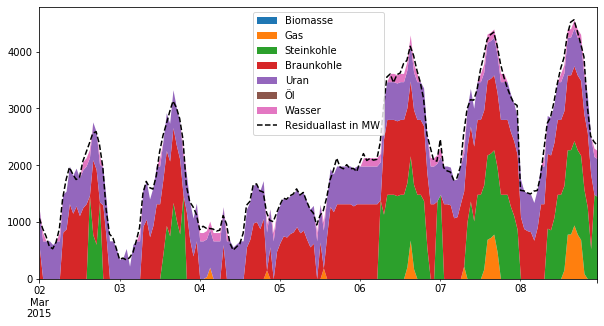

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
Production.plot.area(ax=ax, stacked=True, linewidth=0)
df_res_load_cropped.plot(ax=ax, style='--', c='k')
plt.show()

### Ergebnisse: Speicher

In [23]:
# Save production to matrix
matrix= []

for t in T:
    array = []
    array.append(S_in[t].X)
    array.append(S_out[t].X)
    matrix.append(array)
    
# Convert matrix to Dataframe
Storage = pd.DataFrame(matrix)
# Rename columns
Storage.columns = ['S_in', 'S_out']
# Set index to timestamp
Storage.set_index(df_res_load_cropped.index, inplace=True)
# Convert S_in in negative values
Storage['S_in'] *= -1 #Storage['S_in']=Storage['S_in']*-1

Storage.tail()

,S_in,S_out
2015-03-08 19:00:00+00:00,-0.0,200.000
2015-03-08 20:00:00+00:00,-200.0,0.000
2015-03-08 21:00:00+00:00,-0.0,0.000
2015-03-08 22:00:00+00:00,-0.0,115.075
2015-03-08 23:00:00+00:00,-0.0,84.925


In [24]:
df_plot = pd.concat([Production, Storage], axis=1)
df_plot.head()

,Biomasse,Gas,Steinkohle,Braunkohle,Uran,Öl,Wasser,S_in,S_out
2015-03-02 00:00:00+00:00,0.0,0.0,0.0,549.575,666.0000,0.0,0.0,-152.2250,0.000
2015-03-02 01:00:00+00:00,0.0,0.0,0.0,0.000,666.0000,0.0,146.0,-0.0000,69.375
2015-03-02 02:00:00+00:00,0.0,0.0,0.0,0.000,666.0000,0.0,0.0,-0.0000,82.850
2015-03-02 03:00:00+00:00,0.0,0.0,0.0,0.000,666.0000,0.0,0.0,-99.9750,0.000
2015-03-02 04:00:00+00:00,0.0,0.0,0.0,0.000,601.1125,0.0,0.0,-75.0375,0.000


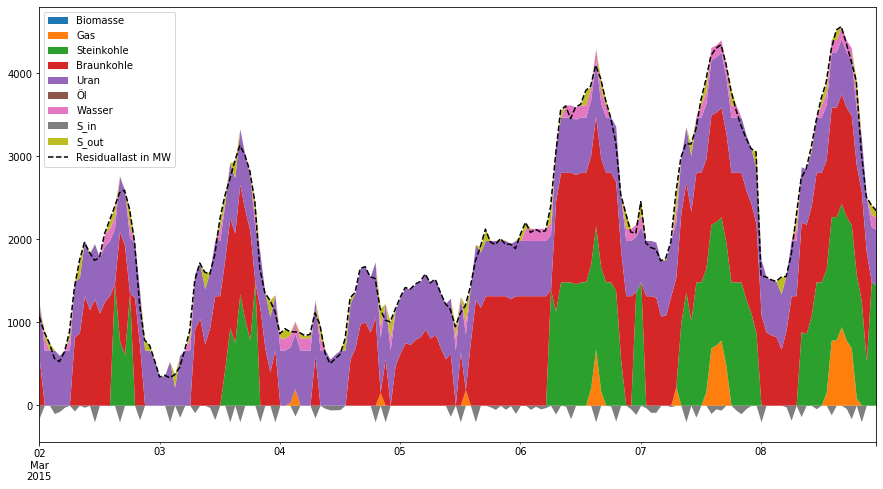

In [25]:
fig, ax = plt.subplots(figsize=(15,8))
df_plot.plot.area(ax=ax, stacked=True, linewidth=0)
df_res_load_cropped.plot(ax=ax, style='--', c='k')
plt.show()

### Ergebnisse: Emissionen

In [26]:
# Save production to matrix
matrix= []
for t in T:
    array = []
    for i in I:
        array.append(E[t,i].X)
    matrix.append(array)
# Convert matrix to Dataframe
Emissionen = pd.DataFrame(matrix)
# Rename columns
Emissionen.columns = ['Biomasse', 'Gas', 'Steinkohle', 'Braunkohle', 'Uran', 'Öl', 'Wasser']
# Set index to timestamp
Emissionen.set_index(df_res_load_cropped.index, inplace=True)

Emissionen.tail()

,Biomasse,Gas,Steinkohle,Braunkohle,Uran,Öl,Wasser
2015-03-08 19:00:00+00:00,0.0,40711.125,1324917.000,1617000.0,0.0,0.0,0.0
2015-03-08 20:00:00+00:00,0.0,0.000,1120254.300,1617000.0,0.0,0.0,0.0
2015-03-08 21:00:00+00:00,0.0,0.000,469066.950,1617000.0,0.0,0.0,0.0
2015-03-08 22:00:00+00:00,0.0,0.000,1324917.000,0.0,0.0,0.0,0.0
2015-03-08 23:00:00+00:00,0.0,0.000,1290368.475,0.0,0.0,0.0,0.0


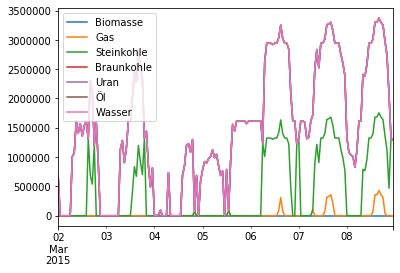

In [27]:
Emissionen.plot(stacked=True)
plt.show()